In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os

zip_file_path = '/content/drive/MyDrive/pnuemonia_dataset.zip'
os.chdir(os.path.dirname(zip_file_path))


In [5]:
import zipfile

# Extract the zip file
with zipfile.ZipFile(os.path.basename(zip_file_path), 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_files')

os.chdir('/content/extracted_files')


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/extracted_files/chest_xray/train'
test_dir = '/content/extracted_files/chest_xray/test'
val_dir = '/content/extracted_files/chest_xray/val'

## 1. Descriptive analysis

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2


Train Dataset Distribution:
    Category  Count
0  PNEUMONIA   3875
1     NORMAL   1341

Test Dataset Distribution:
    Category  Count
0  PNEUMONIA    390
1     NORMAL    234


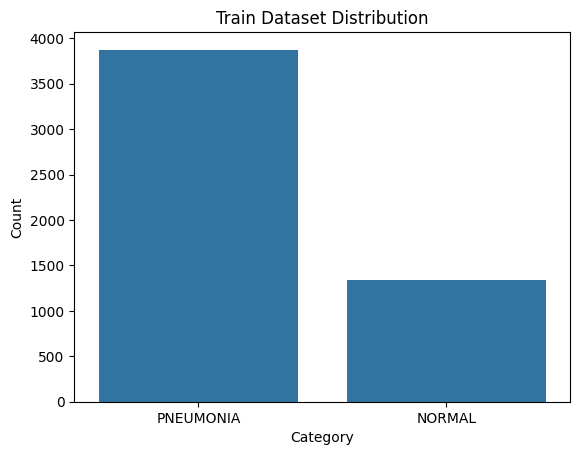

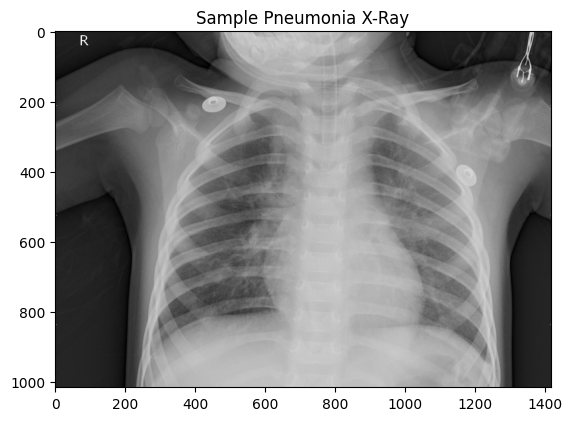

In [8]:
categories = ['PNEUMONIA', 'NORMAL']


train_data = [(category, len(os.listdir(os.path.join(train_dir, category)))) for category in categories]
test_data = [(category, len(os.listdir(os.path.join(test_dir, category)))) for category in categories]

train_df = pd.DataFrame(train_data, columns=['Category', 'Count'])
test_df = pd.DataFrame(test_data, columns=['Category', 'Count'])

print("Train Dataset Distribution:")
print(train_df)

print("\nTest Dataset Distribution:")
print(test_df)

# Visualization
sns.barplot(x='Category', y='Count', data=train_df)
plt.title("Train Dataset Distribution")
plt.show()

sample_img = cv2.imread(os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0]))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title("Sample Pneumonia X-Ray")
plt.show()

## 2. Diagnostic analysis

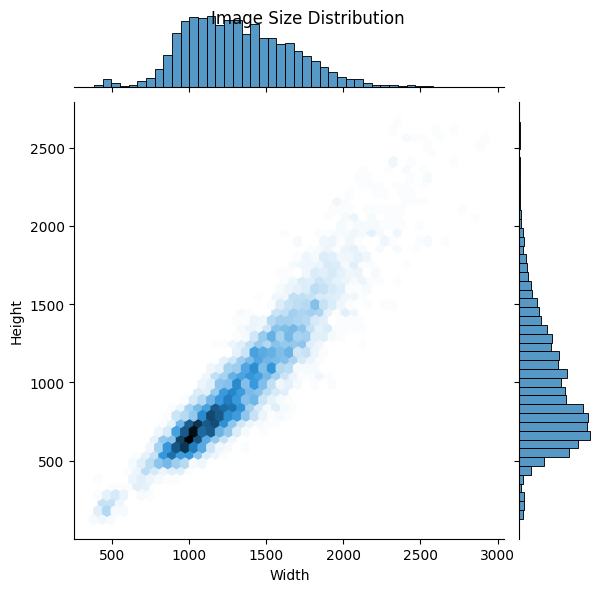

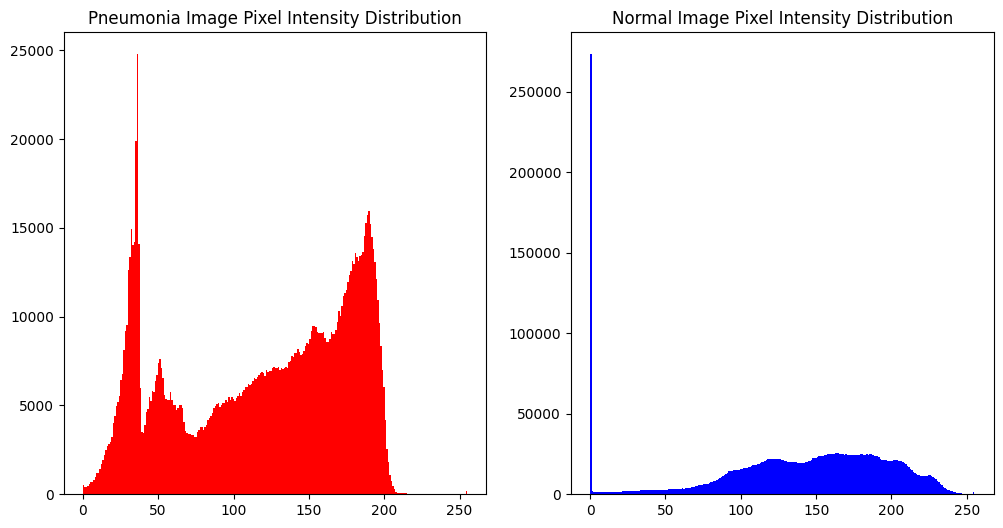

In [9]:
# Analyze image sizes
image_sizes = [cv2.imread(os.path.join(train_dir, category, filename)).shape[:2]
               for category in categories for filename in os.listdir(os.path.join(train_dir, category))]
image_sizes_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])

sns.jointplot(x='Width', y='Height', data=image_sizes_df, kind='hex')
plt.suptitle("Image Size Distribution")
plt.show()

# Analyze pixel intensity distributions
sample_pneumonia_img = cv2.imread(os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0]), cv2.IMREAD_GRAYSCALE)
sample_normal_img = cv2.imread(os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0]), cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(sample_pneumonia_img.ravel(), bins=256, color='red')
axs[0].set_title("Pneumonia Image Pixel Intensity Distribution")
axs[1].hist(sample_normal_img.ravel(), bins=256, color='blue')
axs[1].set_title("Normal Image Pixel Intensity Distribution")
plt.show()


## VGG16

In [10]:


train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        color_mode = 'rgb',
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=64,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='binary')


val_generator = test_datagen.flow_from_directory(
        val_dir,
        color_mode = 'rgb',
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
test_dir,
color_mode = 'rgb',
target_size=(224, 224),
batch_size=64,
class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
from tensorflow.keras import backend as K

def recall_custom(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_custom(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_custom(y_true, y_pred):
    precision = precision_custom(y_true, y_pred)
    recall = recall_custom(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
import tensorflow as tf
import time
base_model_vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

for layer in base_model_vgg16.layers:
    layer.trainable = False

model_vgg16=tf.keras.models.Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.7),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_custom])
model_vgg16.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 2048)              51382272  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                         

In [25]:
start_time = time.time()

history_vgg16 = model_vgg16.fit(train_generator, validation_data=val_generator, epochs=40)

end_time = time.time()

print("Training duration: ", end_time-start_time)

Epoch 1/40
82/82 [==============================] - 91s 1s/step - loss: 0.2560 - accuracy: 0.8898 - f1_custom: 0.9255 - val_loss: 0.3698 - val_accuracy: 0.8125 - val_f1_custom: 0.8421
Epoch 2/40
82/82 [==============================] - 92s 1s/step - loss: 0.2626 - accuracy: 0.8865 - f1_custom: 0.9233 - val_loss: 0.4138 - val_accuracy: 0.8125 - val_f1_custom: 0.8421
Epoch 3/40
82/82 [==============================] - 92s 1s/step - loss: 0.2488 - accuracy: 0.8911 - f1_custom: 0.9265 - val_loss: 0.3752 - val_accuracy: 0.8125 - val_f1_custom: 0.8421
Epoch 4/40
82/82 [==============================] - 91s 1s/step - loss: 0.2617 - accuracy: 0.8869 - f1_custom: 0.9219 - val_loss: 0.3875 - val_accuracy: 0.8125 - val_f1_custom: 0.8421
Epoch 5/40
82/82 [==============================] - 91s 1s/step - loss: 0.2700 - accuracy: 0.8813 - f1_custom: 0.9187 - val_loss: 0.4336 - val_accuracy: 0.8125 - val_f1_custom: 0.8421
Epoch 6/40
82/82 [==============================] - 91s 1s/step - loss: 0.2673 -

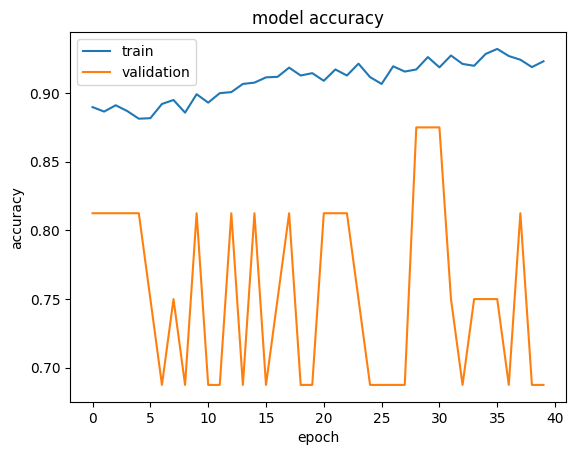

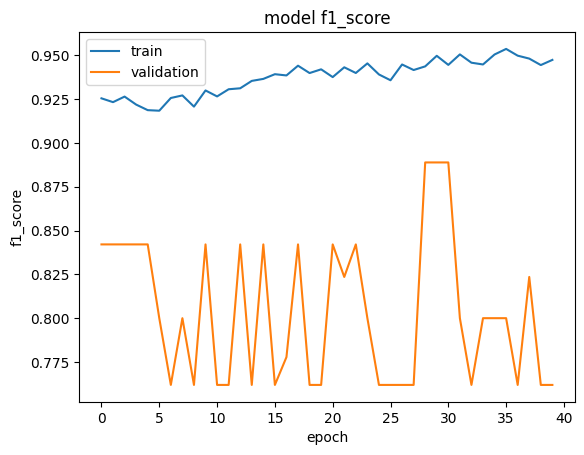

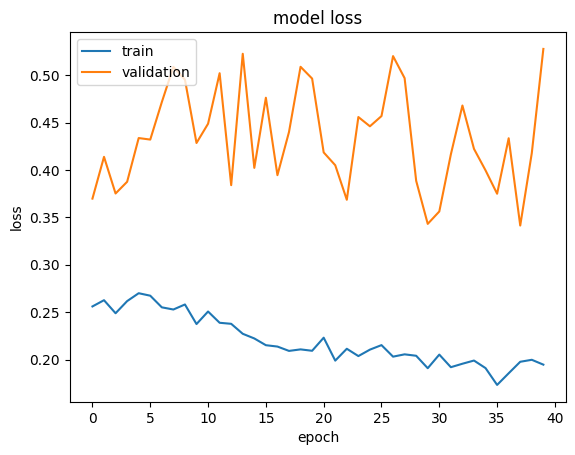

In [26]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for f1_score
plt.plot(history_vgg16.history['f1_custom'])
plt.plot(history_vgg16.history['val_f1_custom'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
model_vgg16.evaluate(test_generator)

10/10 [==============================] - 6s 648ms/step - loss: 0.3353 - accuracy: 0.8574 - f1_custom: 0.8972


[0.33528050780296326, 0.8573718070983887, 0.8972302675247192]

## Custom Model

In [12]:
train_datagen_for_custom = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True)

# Note that the validation data should not be augmented!
test_datagen_for_custom = ImageDataGenerator(rescale=1./255)

train_generator_for_custom = test_datagen_for_custom.flow_from_directory(
        # This is the target directory
        train_dir,
        color_mode = 'grayscale',
        # All images will be resized to 150x150
        target_size=(300, 300),
        batch_size=64,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='binary')

val_generator_for_custom = test_datagen_for_custom.flow_from_directory(
        val_dir,
        color_mode = 'grayscale',
        target_size=(300, 300),
        batch_size=64,
        class_mode='binary')

test_generator_for_custom = test_datagen_for_custom.flow_from_directory(
        test_dir,
        color_mode = 'grayscale',
        target_size=(300, 300),
        batch_size=64,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
import tensorflow as tf

# Define ReLU6 activation
relu6 = tf.keras.layers.ReLU(6.)

def _conv_block(inputs, filters, kernel, strides):
    x = tf.keras.layers.Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    return relu6(x)


def _bottleneck(inputs, filters, kernel, t, s, r=False):
    tchannel = inputs.shape[-1] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = relu6(x)

    x = tf.keras.layers.Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x


def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x


def MobileNetV2(input_shape, k, plot_model=False):
    inputs = tf.keras.layers.Input(shape=input_shape, name='input')
    x = _conv_block(inputs, 64, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 64, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=1)
    x = _inverted_residual_block(x, 128, (3, 3), t=6, strides=2, n=1)
    x = _inverted_residual_block(x, 128, (3, 3), t=6, strides=2, n=1)

    x = _inverted_residual_block(x, 256, (3, 3), t=6, strides=2, n=1)
    x = _inverted_residual_block(x, 256, (3, 3), t=6, strides=1, n=1)

    x = tf.keras.layers.Dropout(0.3, name='Dropout')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', name='final_activation')(x)
    model = tf.keras.models.Model(inputs, x)
    model.summary()
    if plot_model:
        tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [14]:
custom_model_mobilenet = MobileNetV2((300, 300, 1), 1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 300, 300, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 150, 150, 64)         640       ['input[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 150, 150, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                multiple                     0         ['batch_normalization[0][0

In [19]:
# Define a callback for reducing the learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


In [21]:
import time
custom_model_mobilenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_custom])
start_time = time.time()

history_custom_mobilenet = custom_model_mobilenet.fit(
    train_generator_for_custom,
    validation_data=val_generator_for_custom,
    epochs=40,
    callbacks=[reduce_lr]  # learning rate scheduler
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/40
82/82 [==============================] - 40s 370ms/step - loss: 0.0430 - accuracy: 0.9908 - f1_custom: 0.9938 - val_loss: 4.8043 - val_accuracy: 0.5000 - val_f1_custom: 0.6000 - lr: 0.0010
Epoch 2/40
82/82 [==============================] - 30s 364ms/step - loss: 0.0230 - accuracy: 0.9929 - f1_custom: 0.9951 - val_loss: 2.6639 - val_accuracy: 0.5625 - val_f1_custom: 0.6957 - lr: 0.0010
Epoch 3/40
82/82 [==============================] - 31s 371ms/step - loss: 0.0691 - accuracy: 0.9850 - f1_custom: 0.9900 - val_loss: 2.6389 - val_accuracy: 0.5625 - val_f1_custom: 0.6667 - lr: 0.0010
Epoch 4/40
82/82 [==============================] - 30s 364ms/step - loss: 0.0380 - accuracy: 0.9883 - f1_custom: 0.9922 - val_loss: 1.8302 - val_accuracy: 0.7500 - val_f1_custom: 0.8000 - lr: 0.0010
Epoch 5/40
82/82 [==============================] - 31s 370ms/step - loss: 0.0317 - accuracy: 0.9908 - f1_custom: 0.9938 - val_loss: 0.5416 - val_accuracy: 0.8125 - val_f1_custom: 0.8421 - lr: 0.0010


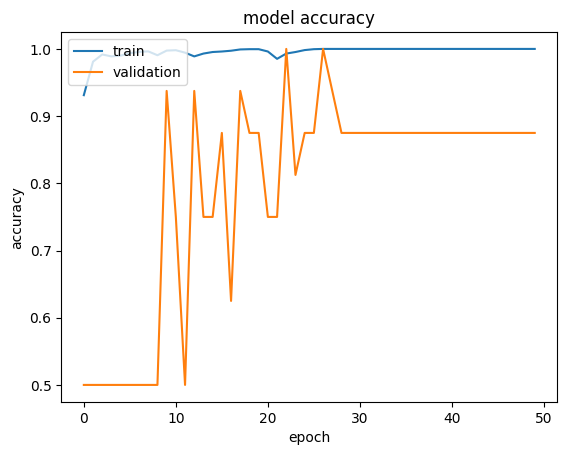

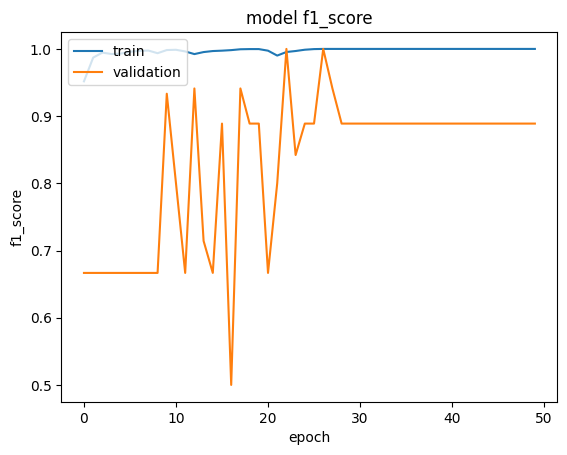

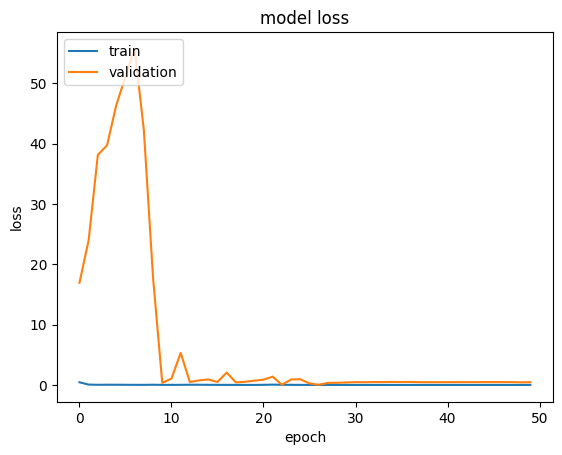

In [17]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_custom_mobilenet.history['accuracy'])
plt.plot(history_custom_mobilenet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for f1_score
plt.plot(history_custom_mobilenet.history['f1_custom'])
plt.plot(history_custom_mobilenet.history['val_f1_custom'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_custom_mobilenet.history['loss'])
plt.plot(history_custom_mobilenet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
custom_model_mobilenet.evaluate(test_generator_for_custom)

10/10 [==============================] - 3s 293ms/step - loss: 5.1353 - accuracy: 0.7372 - f1_custom: 0.8241


[5.135324954986572, 0.7371794581413269, 0.8241134881973267]

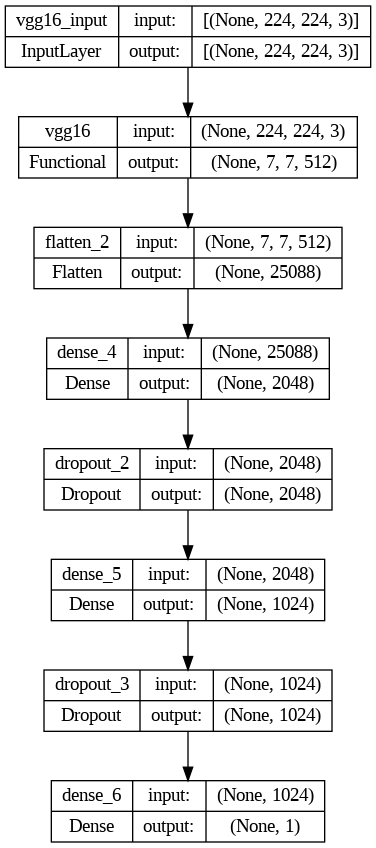

In [28]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

# Constructing the VGG16-based model
base_model_vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in base_model_vgg16.layers:
    layer.trainable = False

model_vgg16 = tf.keras.models.Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.7),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Plotting the model architecture
plot_model(
    model_vgg16,
    to_file='vgg16_model_architecture.png',
    show_shapes=True,
    show_layer_names=True
)


## ResNet 50

In [43]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import Flatten, Dense, Dropout
import tensorflow as tf

base_model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

for layer in base_model_resnet.layers:
    layer.trainable = False

resnet_model = Sequential([
    base_model_resnet,
    Flatten(),
    Dense(2048, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.8),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])


In [44]:
resnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', f1_custom])
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_16 (Dense)            (None, 2048)              205522944 
                                                                 
 batch_normalization_19 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 1024)              2098176   
                                                      

In [45]:
# Start training
start_time = time.time()

history_resnet = resnet_model.fit(train_generator, validation_data=val_generator, epochs=5)

end_time = time.time()

print("Training duration: ", end_time-start_time)

Epoch 1/5
82/82 [==============================] - 96s 1s/step - loss: 3.2405 - accuracy: 0.7159 - f1_custom: 0.7799 - val_loss: 3.0334 - val_accuracy: 0.5000 - val_f1_custom: 0.0000e+00
Epoch 2/5
82/82 [==============================] - 91s 1s/step - loss: 1.8179 - accuracy: 0.7667 - f1_custom: 0.8249 - val_loss: 2.2282 - val_accuracy: 0.5000 - val_f1_custom: 0.0000e+00
Epoch 3/5
82/82 [==============================] - 91s 1s/step - loss: 1.6335 - accuracy: 0.7918 - f1_custom: 0.8482 - val_loss: 2.7128 - val_accuracy: 0.5000 - val_f1_custom: 0.0000e+00
Epoch 4/5
82/82 [==============================] - 91s 1s/step - loss: 1.5369 - accuracy: 0.8098 - f1_custom: 0.8636 - val_loss: 2.0199 - val_accuracy: 0.6250 - val_f1_custom: 0.7273
Epoch 5/5
82/82 [==============================] - 91s 1s/step - loss: 1.4694 - accuracy: 0.8167 - f1_custom: 0.8708 - val_loss: 2.7833 - val_accuracy: 0.6250 - val_f1_custom: 0.7273
Training duration:  460.73126769065857


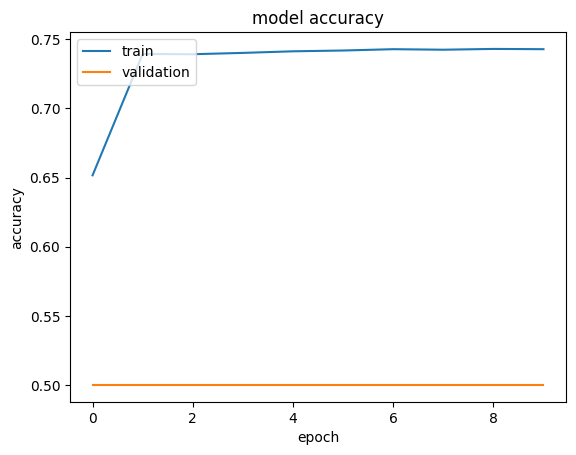

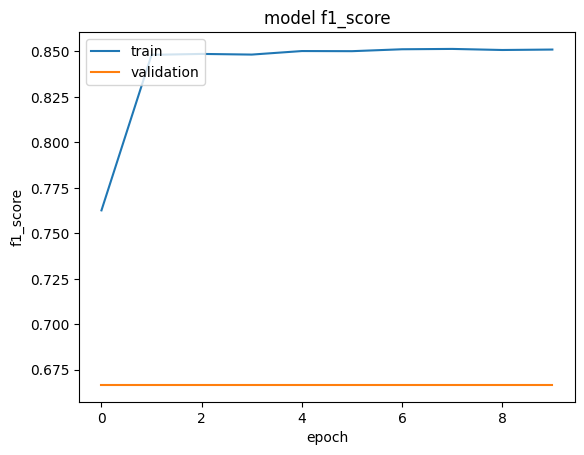

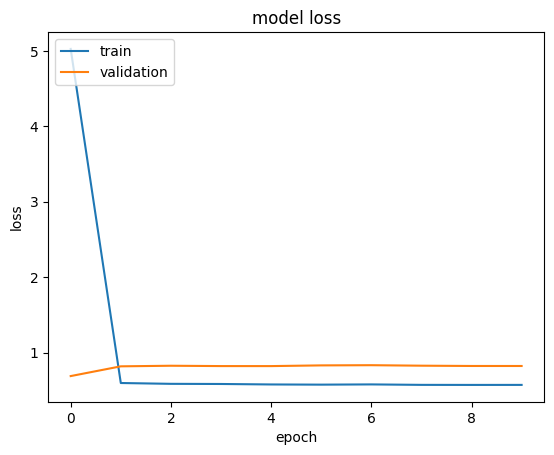

In [40]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for f1_score
plt.plot(history_resnet.history['f1_custom'])
plt.plot(history_resnet.history['val_f1_custom'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_f1 = resnet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1}")

10/10 [==============================] - 5s 447ms/step - loss: 0.6921 - accuracy: 0.6250 - f1_custom: 0.7680
Test Loss: 0.6920880675315857
Test Accuracy: 0.625
Test F1 Score: 0.7679542303085327


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 131072)            0         
                                                                 
 dense_25 (Dense)            (None, 2048)              268437504 
                                                                 
 batch_normalization_25 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                               

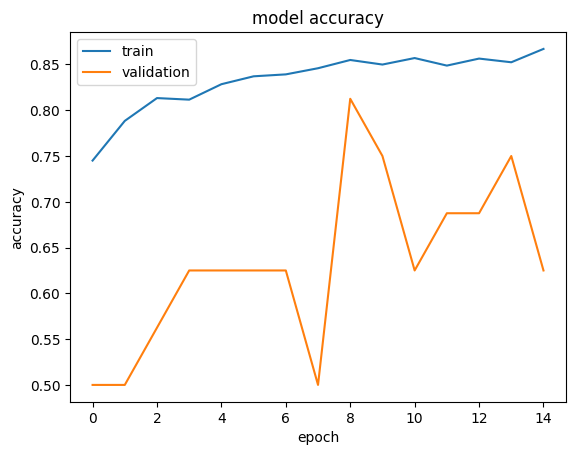

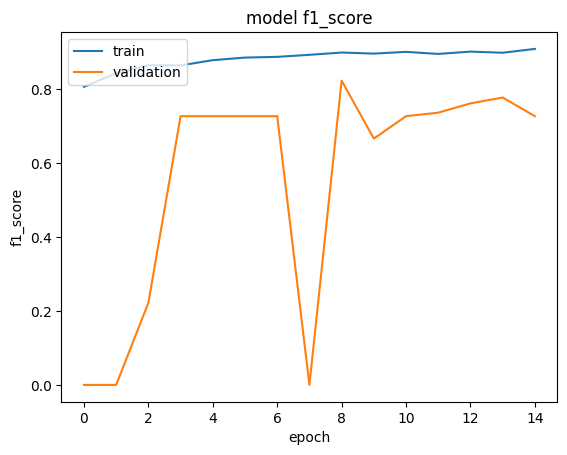

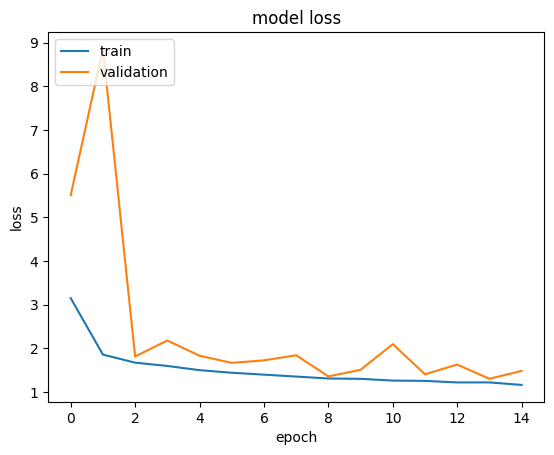

10/10 [==============================] - 5s 470ms/step - loss: 1.1794 - accuracy: 0.8333 - f1_custom: 0.8650
Test Loss: 1.1794
Test Accuracy: 0.8333
Test F1 Score: 0.8650


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import matplotlib.pyplot as plt
import time

train_dir = '/content/extracted_files/chest_xray/train'
test_dir = '/content/extracted_files/chest_xray/test'
val_dir = '/content/extracted_files/chest_xray/val'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Increase the target size for validation and testing
image_size = (256, 256)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=image_size,
    batch_size=64,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=image_size,
    batch_size=64,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',
    target_size=image_size,
    batch_size=64,
    class_mode='binary'
)

from tensorflow.keras import backend as K

def recall_custom(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_custom(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_custom(y_true, y_pred):
    precision = precision_custom(y_true, y_pred)
    recall = recall_custom(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

base_model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Freeze all layers in the base model
for layer in base_model_resnet.layers:
    layer.trainable = False

resnet_model = Sequential([
    base_model_resnet,
    Flatten(),
    Dense(2048, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.8),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

resnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', f1_custom])
resnet_model.summary()

start_time = time.time()
history_resnet = resnet_model.fit(train_generator, validation_data=val_generator, epochs=15)
end_time = time.time()

print("Training duration: ", end_time - start_time)

plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for f1_score
plt.plot(history_resnet.history['f1_custom'])
plt.plot(history_resnet.history['val_f1_custom'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy, test_f1 = resnet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


In [49]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_f1 = resnet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

10/10 [==============================] - 5s 474ms/step - loss: 1.1793 - accuracy: 0.8333 - f1_custom: 0.8657
Test Loss: 1.1793
Test Accuracy: 0.8333
Test F1 Score: 0.8657
